Decido usar este Dataset ya que estaba usando uno de Metales raros de Quandl. La unica manera de descargar esos datasets es con Import Quandl y la funcion de quandl.get('Codigo'). Me bloquearon el acceso por falta de API, lo cual es completamente nuevo para mi ya que he hecho otros requests a Quandl de la misma manera con mas datos. Despues que me bloquearon, solo tenia un dataset con muy poca informacion, eran 3692 lineas. Lo que queria predecir era el precio de acuerdo a la region, pero como aca en este dataset no hay region, usare solo el precio para predecir. Si tengo tiempo, tratare de usar otras columnas.

# Import

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import sklearn
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv('diamonds.csv', index_col = 0)

# Navigating through the data

In [4]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Let's take a good at the features of the dataset. We will also describe the whole dataset to show a few maybe useful insights.

In [5]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Now let's take a look at the columns types.

In [6]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

As we can see, we have 3 columns which we will have to convert into numerical values. We can do this with .values (A function of Numpy) or with get dummies. 

In [7]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

There are no null values, that is going to help us a lot.

Now, we will proceed to Create a heatmap of the dataset.

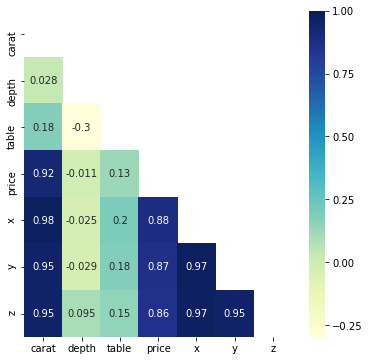

In [8]:
mask = np.zeros_like(df.corr(), dtype=np.bool)

mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(df.corr(), mask=mask, annot=True, cmap="YlGnBu")

Let's see how many unique values are there in the Object type columns.

In [9]:
display(df['cut'].unique())
display(df['color'].unique())
display(df['clarity'].unique())

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

We have a little problem. I wanted to use the get_dummies function, but, the model will not identify which is better between Ideal or Premium and so on. The same happens with the other object type features, In the color feature, E is a lower quality according to Wikipedia. (Not exactly a lower quality, it's just less rare and less expensive)

We will assign the values by hand using a dictionary and a Map function.

# Classifying data.

In [10]:
cut_dict = {'Ideal':5, 'Premium':4, 'Good':3, 'Very Good':2, 'Fair':1}
color_dict = {'D':7, 'E':6, 'F':5, 'G':4, 'H':3, 'I':2, 'J':1}
clarity_dict = {"FL": 11, "IF": 10, "VVS1": 9, "VVS2": 8, "VS1": 7, "VS2": 6, "SI1": 5, "SI2": 4, "I1": 3, "I2": 2, "I3": 1}

def cambiarValores(x, dict):
    df[x] = df[x].map(dict)
    return df[x]
cambiarValores('cut', cut_dict)
cambiarValores('color', color_dict)
cambiarValores('clarity', clarity_dict)

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,5,6,4,61.5,55.0,326,3.95,3.98,2.43
2,0.21,4,6,5,59.8,61.0,326,3.89,3.84,2.31
3,0.23,3,6,7,56.9,65.0,327,4.05,4.07,2.31
4,0.29,4,2,6,62.4,58.0,334,4.20,4.23,2.63
5,0.31,3,1,4,63.3,58.0,335,4.34,4.35,2.75


# Training the model

Now we will train the dataset with the function train_test_split from sklearn and the test size sample will be 10%. And, we will shuffle the data.

We will scale the training data of the whole dataset except for Price.

In [63]:
X = df.drop("price", axis=1).values
y = df["price"].values
X = preprocessing.scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

# Stochastic Gradient Descent Regression

In [12]:
clf = SGDRegressor(max_iter=1000)
clf.fit(X_train, y_train)
display(clf.score(X_test, y_test))

C:\Users\aleja\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.9055556273411004

In [13]:
for X,y in list(zip(X_test, y_test))[:10]:
    display(f"Model: {clf.predict([X])[0]}, Actual: {y}")

'Model: 2502.303832054253, Actual: 957'

'Model: 9393.505921603675, Actual: 10951'

'Model: 17827.01748638072, Actual: 17028'

'Model: 7820.896890804817, Actual: 9399'

'Model: 2095.2664099779736, Actual: 1174'

'Model: 1691.7573221164184, Actual: 1764'

'Model: 709.5491405693701, Actual: 972'

'Model: 5955.912216679202, Actual: 5767'

'Model: 1117.6773132483959, Actual: 761'

'Model: 1359.112510491485, Actual: 1289'

We can observe the model actual accuracy by sample. In some tests it even suggest we pay for us to get rid of the diamond. We will assume it was a radioactive diamond, good job machine.

# Support Vector Machines

We'll be using the Support Vector Regression and the kernel will be set up to be Linear.

In [15]:
clf2 = svm.SVR(kernel='linear')

clf2.fit(X_train, y_train)
display(clf2.score(X_test, y_test))

0.8664601660992093

In [16]:
for X,y in list(zip(X_test, y_test))[:10]:
    display(f"Model: {clf2.predict([X])[0]}, Actual: {y}")

'Model: 1462.974166492963, Actual: 957'

'Model: 8342.141320167133, Actual: 10951'

'Model: 14948.563639100834, Actual: 17028'

'Model: 6951.421272979729, Actual: 9399'

'Model: 1278.9707313121098, Actual: 1174'

'Model: 1601.109967289797, Actual: 1764'

'Model: 496.4773287671819, Actual: 972'

'Model: 5181.529757368156, Actual: 5767'

'Model: 1064.4645496460662, Actual: 761'

'Model: 1475.1286407297025, Actual: 1289'

In this model, we have less accuracy and still the same problems of giving away free radioactive diamonds

Let's see how it works if we change the kernel from linear to 'rbf'. Maybe with that, we will see improvement.
Although im not going to display the model vs the actual as I did in the previous ones. (It will not vary much)

In [17]:
clf3 = svm.SVR(kernel='rbf')

clf3.fit(X_train, y_train)
display(clf3.score(X_test, y_test))

C:\Users\aleja\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5514667630726988

And it works pretty bad. We will just assume this model is giving away all my diamonds. Or it is charging way up to heal the mistake of giving away diamonds of the other 2 and that is why it is so bad at predicting. (It's just bad)

#  Generalized Linear Models

 In this cathegory we will only be using the Lasso method. Maybe this one can dethrone SGDr

In [66]:
clf4 = linear_model.Lasso()

clf4.fit(X_train, y_train)
display(clf4.score(X_test, y_test))

0.9037716816104183

This model suits really well my dataset. There is a tie between SGDr and this one.

In [65]:
reg = LassoLarsCV(cv=5).fit(X_train, y_train)
reg.score(X_test, y_test)

0.9037136915194474

In [67]:
y_pred = clf4.predict(X_test)

Compruebo si con usar Cross_Validation cambia algo, no cambia nada. Es obsoleto el cambio.

# ROC Curve